<a href="https://colab.research.google.com/github/jpantojaj/DIP-CS_AI/blob/main/Credit_Scoring_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Carga Inicial de Librerías**

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline

## **2. Carga y Análisis inicial de datos**

In [ ]:
df_val = pd.read_csv('Base_SolicitudesCreditoEfectivo_Val.csv', sep = ",")
df_val.head()

,CODMES,CODSOLICITUD,DEUDA,PLAZO_CREDITO,FLG_GARANTIA,MIN_MES_DE_DEFAULT,SEGMENTOCLIENTE,TARJETA_RELACIONADA,VEHICULAR_RELACIONADA,HIPOTECARIO_RELACIONADA,...,PROFESION,ZONA_DEL_DESEMBOLSO,ESTADO_CIVIL,EDAD_T,CUOTA,LINEA_DE_TC,MONTO_TC_MEMBRESIA,FLG_TC_VISA,FLG_TC_MC,FLG_DEFAULT_12M
0,201504,27073,2532.525833,48,0,NaN,CLIENTES ORO,0,0,0,...,CONTADOR,SAN_MARTIN,SOL,30.0,0.000000,6133.0,114.0,1.0,1.0,0
1,201311,8037,3044.511917,12,0,NaN,CLIENTES PLATINUM SEGM 2,1,0,0,...,OTROS MEDICINA,LIMA_MODERNA,VIU,68.0,1791.355242,84120.0,350.0,0.0,0.0,0
2,201404,841,1347.129167,36,0,NaN,CLIENTES ORO,1,0,0,...,TECNICO,ANCASH,SOL,42.0,270.484368,13300.0,80.0,0.0,0.0,0
3,201406,14861,4437.308561,36,0,NaN,CLIENTES ORO,0,0,0,...,TECNICO,ANCASH,SOL,35.0,418.320693,9015.0,102.0,1.0,1.0,0
4,201406,13694,2691.641667,36,0,NaN,CLIENTES ORO,0,0,0,...,TECNICO,JUNIN,CON,28.0,0.000000,2651.0,105.0,1.0,1.0,0


In [ ]:
df_val['CODMES']=df_val['CODMES'].astype(str)
df_val['CODSOLICITUD']=df_val['CODSOLICITUD'].astype(str)
df_val['MIN_MES_DE_DEFAULT']=df_val['MIN_MES_DE_DEFAULT'].astype(str)
df_val['FLG_GARANTIA']=df_val['FLG_GARANTIA'].astype(str)
df_val['TARJETA_RELACIONADA']=df_val['TARJETA_RELACIONADA'].astype(str)
df_val['VEHICULAR_RELACIONADA']=df_val['VEHICULAR_RELACIONADA'].astype(str)
df_val['HIPOTECARIO_RELACIONADA']=df_val['HIPOTECARIO_RELACIONADA'].astype(str)
df_val['CLASIF_SISTEMA_ULT_12M']=df_val['CLASIF_SISTEMA_ULT_12M'].astype(str)
df_val['FLG_PDH']=df_val['FLG_PDH'].astype(str)
df_val['FLG_TC_VISA']=df_val['FLG_TC_VISA'].astype(str)
df_val['FLG_TC_MC']=df_val['FLG_TC_MC'].astype(str)

# Buen_Pagador: 4486
# 1 Mora_12M: 306
Bad rate: 0.06385642737896494


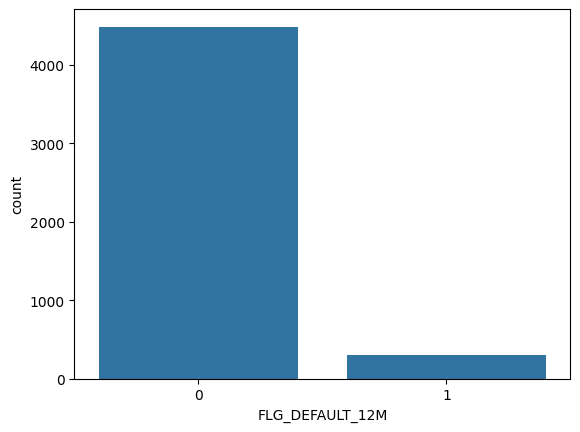

In [ ]:
sns.countplot(data = df_val, x = "FLG_DEFAULT_12M")
target_count = df_val.FLG_DEFAULT_12M.value_counts()
print('# Buen_Pagador:', target_count[0])
print('# 1 Mora_12M:', target_count[1])
print('Bad rate:', target_count[1]/(target_count[0]+target_count[1]))

<Axes: xlabel='CODMES'>

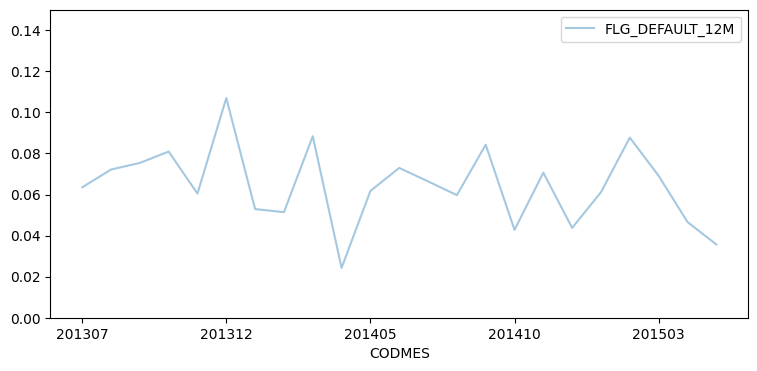

In [ ]:
a2=df_val.pivot_table(values="FLG_DEFAULT_12M", index="CODMES", aggfunc="mean", sort=True)
a2.plot(alpha = 0.4, figsize=(9,4), ylim=(0.0,0.15))

## **3. Carga de los artefactos desarrollados en el entrenamiento**

In [ ]:
import pickle

In [ ]:
pip install feature_engine

In [ ]:
# Cargar el pipeline del feature engineering
with open('fe_pipeline.pkl','rb') as fe_data_file:
     fe_final = pickle.load(fe_data_file)

In [ ]:
# Cargar el modelo
with open('final_model.pkl','rb') as modelFile:
     modelo_final = pickle.load(modelFile)

In [ ]:
#Probemos el pipeline
df_val_xt=fe_final.transform(df_val.drop(['FLG_DEFAULT_12M'],axis=1))
df_val_y=df_val['FLG_DEFAULT_12M']

In [ ]:
tot_df_val_xt=pd.concat([df_val_xt, df_val_y],axis=1)

## **2. Pruebas de Validación**

### **Boostrapping**

In [ ]:
from sklearn.model_selection  import KFold, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score

In [ ]:
bootstrap_iter = 50

In [ ]:
roc_auc = []

In [ ]:
for i in range(bootstrap_iter):
    X_, y_ = resample(df_val_xt, df_val_y)
    #gbc.fit(X_, y_)
    y_pred = modelo_final.predict_proba(X_)
    acc = roc_auc_score(y_,y_pred[:,1])
    roc_auc.append(acc)

In [ ]:
roc_auc_final = np.array(roc_auc)

In [ ]:
roc_auc_final

array([0.74137119, 0.74233924, 0.74070458, 0.74130964, 0.72301454,
       0.74331256, 0.74085396, 0.73423354, 0.71280811, 0.72764237,
       0.73964899, 0.76088372, 0.73575167, 0.74724435, 0.75679583,
       0.74139776, 0.75303988, 0.73542667, 0.72556331, 0.76665233,
       0.75087705, 0.73979449, 0.75244641, 0.75167893, 0.74016923,
       0.72868059, 0.74776841, 0.75673422, 0.71427957, 0.75371921,
       0.75716348, 0.7475093 , 0.73535913, 0.75274862, 0.73782997,
       0.75026117, 0.74225928, 0.7525881 , 0.74436436, 0.74200164,
       0.77256744, 0.75630208, 0.72325124, 0.73421412, 0.74543096,
       0.73711568, 0.71980232, 0.72241794, 0.72480757, 0.75490597])

In [ ]:
gini_final=2*roc_auc_final-1

In [ ]:
gini_final

array([0.48274239, 0.48467848, 0.48140916, 0.48261928, 0.44602909,
       0.48662511, 0.48170792, 0.46846709, 0.42561623, 0.45528474,
       0.47929798, 0.52176744, 0.47150335, 0.4944887 , 0.51359166,
       0.48279551, 0.50607977, 0.47085333, 0.45112661, 0.53330467,
       0.5017541 , 0.47958899, 0.50489282, 0.50335786, 0.48033846,
       0.45736117, 0.49553681, 0.51346845, 0.42855915, 0.50743842,
       0.51432695, 0.49501859, 0.47071826, 0.50549724, 0.47565993,
       0.50052234, 0.48451856, 0.5051762 , 0.48872872, 0.48400328,
       0.54513488, 0.51260417, 0.44650247, 0.46842824, 0.49086191,
       0.47423135, 0.43960463, 0.44483589, 0.44961514, 0.50981194])

In [ ]:
print('Gini')
print('Average: ', gini_final.mean())
print('Standard deviation: ', gini_final.std())

Gini
Average:  0.4839617086449466
Standard deviation:  0.025841670215512518


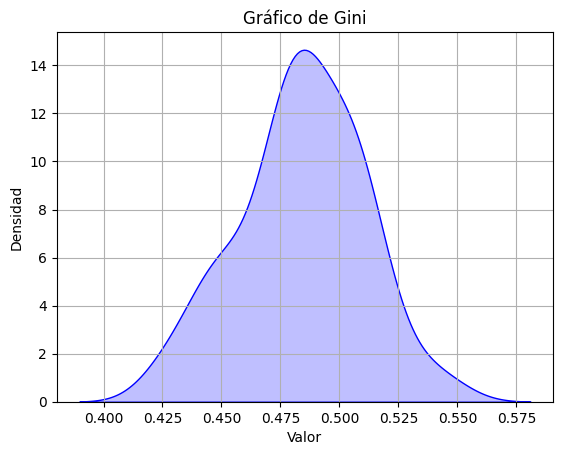

In [ ]:
sns.kdeplot(gini_final, shade=True, color='blue')
plt.title('Gráfico de Gini')
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.grid(True)
plt.show()

### **K-Folds Cross Validation**

In [ ]:
k = 50

In [ ]:
kfold = KFold(n_splits = k, random_state = 777, shuffle=True)

In [ ]:
results = cross_val_score(modelo_final, df_val_xt, df_val_y, cv = kfold, scoring='roc_auc')

In [ ]:
results

array([0.55434783, 0.77142857, 0.57880435, 0.63043478, 0.70880682,
       0.6244186 , 0.93189964, 0.75095785, 0.58837209, 0.43085106,
       0.83141762, 0.87252747, 0.76043956, 0.61666667, 0.72037037,
       0.85274725, 0.54150702, 0.70465116, 0.73626374, 0.85869565,
       0.74468085, 0.63242376, 0.57182576, 0.75      , 0.76083467,
       0.74184783, 0.73641304, 0.88333333, 0.69444444, 0.48703704,
       0.72085561, 0.6344086 , 0.62105263, 0.85930233, 0.69148936,
       0.81534091, 0.67037037, 0.75815217, 0.73518519, 0.84259259,
       0.83333333, 0.85555556, 0.72835498, 0.62919897, 0.92222222,
       0.69155844, 0.4494382 , 0.88768116, 0.65355805, 0.86891386])

In [ ]:
gini_final=2*results-1

In [ ]:
gini_final

array([ 0.10869565,  0.54285714,  0.1576087 ,  0.26086957,  0.41761364,
        0.24883721,  0.86379928,  0.50191571,  0.17674419, -0.13829787,
        0.66283525,  0.74505495,  0.52087912,  0.23333333,  0.44074074,
        0.70549451,  0.08301405,  0.40930233,  0.47252747,  0.7173913 ,
        0.4893617 ,  0.26484751,  0.14365153,  0.5       ,  0.52166934,
        0.48369565,  0.47282609,  0.76666667,  0.38888889, -0.02592593,
        0.44171123,  0.2688172 ,  0.24210526,  0.71860465,  0.38297872,
        0.63068182,  0.34074074,  0.51630435,  0.47037037,  0.68518519,
        0.66666667,  0.71111111,  0.45670996,  0.25839793,  0.84444444,
        0.38311688, -0.1011236 ,  0.77536232,  0.3071161 ,  0.73782772])

In [ ]:
print('Gini')
print('Average: ', gini_final.mean())
print('Standard deviation: ', gini_final.std())

Gini
Average:  0.43748053558975714
Standard deviation:  0.24018831598783785


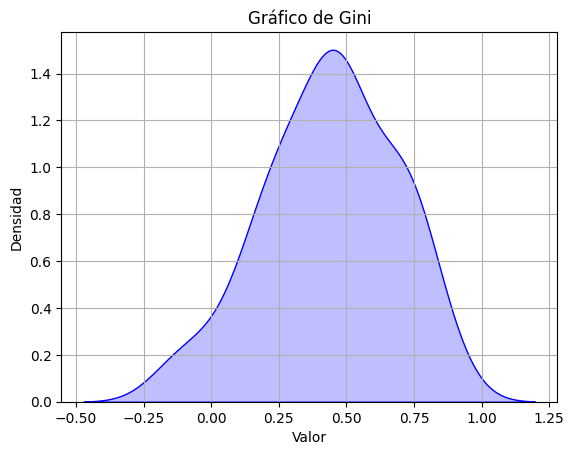

In [ ]:
sns.kdeplot(gini_final, shade=True, color='blue')
plt.title('Gráfico de Gini')
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.grid(True)
plt.show()